In [0]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [2]:
pip install keras_metrics

In [3]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
# importing all necessary libraries to run the code
import re,string
import numpy as np
import pandas as pd
import keras_metrics
import tensorflow.keras
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation,Embedding,GlobalMaxPooling1D
# using the variable sw to hold all stopwords that are in English
sw = stopwords.words('english')

Using TensorFlow backend.


In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
link = 'https://drive.google.com/open?id=0Bz8a_Dbh9QhbaW12WVVZS2drcnM' # The shareable link

In [7]:
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='

0Bz8a_Dbh9QhbaW12WVVZS2drcnM


In [0]:
import gzip
import pandas as pd
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('Filename.csv') 
with open('Filename.csv', 'rb') as fd:
  gzip_fd = gzip.GzipFile(fileobj=fd)
  data = pd.read_csv(gzip_fd, nrows=3000000) 
#df3 = pd.read_csv('Filename.csv')# Dataset is now stored in a Pandas Dataframe

In [0]:
#dependencies 
import requests, zipfile, io, os
from gensim.models.fasttext import FastText

#download model
ft_url = 'https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip'
zpath = 'crawl-300d-2M.vec.zip'
mpath = 'crawl-300d-2M-subword.bin'

if os.path.isfile(zpath):
    #attempt load
    mod = FastText.load_fasttext_format(mpath,encoding='utf-8')
    
elif not os.path.isfile(zpath):
    r = requests.get(ft_url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall()
else:
    z = zipfile.ZipFile(zpath)
    z.extractall()
    mod = FastText.load_fasttext_format(mpath,encoding='utf-8')
   

In [10]:
from tqdm import tqdm
import os, re, csv, math, codecs
#load embeddings
print('loading word embeddings...')
embeddings_index = {}
f = codecs.open('crawl-300d-2M.vec', encoding='utf-8')
for line in tqdm(f):
  values = line.rstrip().rsplit(' ')
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()
print('found %s word vectors' % len(embeddings_index))

1233it [00:00, 12329.57it/s]

loading word embeddings...


1999996it [02:55, 11421.60it/s]

found 1999996 word vectors


In [11]:
data.head(2)

,amazon_review_polarity_csv/,Great CD,"My lovely Pat has one of the GREAT voices of her generation. I have listened to this CD for YEARS and I still LOVE IT. When I'm in a good mood it makes me feel better. A bad mood just evaporates like sugar in the rain. This CD just oozes LIFE. Vocals are jusat STUUNNING and lyrics just kill. One of life's hidden gems. This is a desert isle CD in my book. Why she never made it big is just beyond me. Everytime I play this, no matter black, white, young, old, male, female EVERYBODY says one thing ""Who was that singing ?"""
0,2.0,One of the best game music soundtracks - for a...,Despite the fact that I have only played a sma...
1,1.0,Batteries died within a year ...,I bought this charger in Jul 2003 and it worke...


In [12]:
data.columns=['Target','Headline','HeadlineBody']
data.head(2)

,Target,Headline,HeadlineBody
0,2.0,One of the best game music soundtracks - for a...,Despite the fact that I have only played a sma...
1,1.0,Batteries died within a year ...,I bought this charger in Jul 2003 and it worke...


In [0]:
data['text']= data['Headline']+ ' '+data['HeadlineBody']

In [14]:
data=data.dropna()
data.head(2)

,Target,Headline,HeadlineBody,text
0,2.0,One of the best game music soundtracks - for a...,Despite the fact that I have only played a sma...,One of the best game music soundtracks - for a...
1,1.0,Batteries died within a year ...,I bought this charger in Jul 2003 and it worke...,Batteries died within a year ... I bought this...


In [15]:
data.isnull().sum()

Target          0
Headline        0
HeadlineBody    0
text            0
dtype: int64

In [16]:
#applying pre-processing steps to remove stopwords and words of size less than 2
data['text'] = data['text'].apply(lambda x: x.split())
wordsEng = stopwords.words('english')
data['text'] = data['text'].apply(lambda x:[item for item in x if item not in wordsEng])
data['text'] = data['text'].apply(lambda x: [w for w in x if len(w)>2])
data['text'] = data['text'].apply(lambda x: " ".join(x))
data.head(2)

,Target,Headline,HeadlineBody,text
0,2.0,One of the best game music soundtracks - for a...,Despite the fact that I have only played a sma...,One best game music soundtracks game really pl...
1,1.0,Batteries died within a year ...,I bought this charger in Jul 2003 and it worke...,Batteries died within year ... bought charger ...


In [0]:
data.reset_index(inplace=True)

In [0]:
#removing airline company names as pre-processing
testList=[]
def strip_links(text):
    link_regex    = re.compile('((https?):((//)|(\\\\))+([\w\d:#@%/;$()~_?\+-=\\\.&](#!)?)*)', re.DOTALL)
    links         = re.findall(link_regex, text)
    for link in links:
        text = text.replace(link[0], ', ')    
    return text

def strip_all_entities(text):
    entity_prefixes = ['@','#']
    for separator in  string.punctuation:
        if separator not in entity_prefixes :
            text = text.replace(separator,' ')
    words = []
    for word in text.split():
        word = word.strip()
        if word:
            if word[0] not in entity_prefixes:
                words.append(word)
    return ' '.join(words)


for t in range(len(data)):
    testList.append(strip_all_entities(strip_links(data['text'][t])))

In [19]:
#converting testList[] list into dataframe for further processing
dat = pd.DataFrame(np.array(testList))
dat.head(2)

,0
0,One best game music soundtracks game really pl...
1,Batteries died within year bought charger Jul ...


In [0]:
# applying pre-processing to remove special symbols, numbers and converting into lower case
sw = stopwords.words('english')
twitterSentiment=[]
for i in range(len(dat)):
    review = re.sub('[^a-zA-Z]', ' ',dat[0][i])
    review = re.sub('[/(){}\[\]\|@!,;]', ' ',dat[0][i])
    review = re.sub('[^0-9a-zA-Z #+_♥️]', ' ',dat[0][i])#Remove bad symbols
    
    review = re.sub(r'\d+', '',review)
    review = review.lower()
    review = review.split()

    review = [token for token in review if token not in sw]
    review=' '.join(review)
    review=' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",review).split())
    twitterSentiment.append(review)

In [21]:
#converting twitterSentiment[] list into dataframe for serving it to keras tokenizer
dataSetFinal = pd.DataFrame(np.array(twitterSentiment))
dataSetFinal.head(1)

,0
0,one best game music soundtracks game really pl...


In [0]:
tokenizer = tensorflow.keras.preprocessing.text.Tokenizer(num_words=7500, lower=True,split=' ',filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(dataSetFinal[0].values)
#print(tokenizer.word_index)  # To see the dicstionary
X = tokenizer.texts_to_sequences(dataSetFinal[0].values)
X = tensorflow.keras.preprocessing.sequence.pad_sequences(X)

In [25]:
word_index = tokenizer.word_index
print("dictionary size: ", len(word_index))

dictionary size:  783948


In [0]:
MAX_NB_WORDS = 100000
embed_dim = 300 
max_seq_len =155
#training params
batch_size = 256 
num_epochs = 8 

#model parameters
num_filters = 64 
embed_dim = 300 
weight_decay = 1e-4

In [27]:
#embedding matrix
print('preparing embedding matrix...')
words_not_found = []
nb_words = min(MAX_NB_WORDS, len(word_index))
embedding_matrix = np.zeros((nb_words, embed_dim))
for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 10843


In [32]:
from keras import regularizers
from keras import optimizers
from keras import backend as K
print("training CNN ...")
model = Sequential()
model.add(Embedding(nb_words, embed_dim,
          weights=[embedding_matrix], input_length=max_seq_len, trainable=False))
model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
model.add(MaxPooling1D(2))
model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Dense(2, activation='softmax'))  #multi-label (k-hot encoding)

adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy','mae',keras_metrics.precision(), keras_metrics.recall()])
model.summary()

training CNN ...
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 155, 300)          30000000  
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 155, 64)           134464    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 77, 64)            0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 77, 64)            28736     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 64)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 3

In [0]:
#define callbacks
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=4, verbose=1)
callbacks_list = [early_stopping]

In [33]:
#batch_size=64
Y = pd.get_dummies(data['Target']).values
X_train, X_valid, Y_train, Y_valid = train_test_split(X,Y, test_size = 0.30)
#Here we train the Network.

#model training
hist = model.fit(X_train, Y_train, batch_size=batch_size, epochs=num_epochs, callbacks=callbacks_list, validation_split=0.1, shuffle=True, verbose=2)
hist


Train on 1889956 samples, validate on 209996 samples
Epoch 1/8
 - 775s - loss: 0.2608 - acc: 0.8932 - mean_absolute_error: 0.1567 - precision: 0.8944 - recall: 0.8911 - val_loss: 0.2302 - val_acc: 0.9080 - val_mean_absolute_error: 0.1489 - val_precision: 0.9069 - val_recall: 0.9092
Epoch 2/8
 - 748s - loss: 0.2262 - acc: 0.9092 - mean_absolute_error: 0.1340 - precision: 0.9106 - recall: 0.9072 - val_loss: 0.2300 - val_acc: 0.9115 - val_mean_absolute_error: 0.1566 - val_precision: 0.9091 - val_recall: 0.9145
Epoch 3/8
 - 726s - loss: 0.2144 - acc: 0.9148 - mean_absolute_error: 0.1264 - precision: 0.9158 - recall: 0.9132 - val_loss: 0.2222 - val_acc: 0.9130 - val_mean_absolute_error: 0.1471 - val_precision: 0.9131 - val_recall: 0.9129
Epoch 4/8
 - 721s - loss: 0.2061 - acc: 0.9186 - mean_absolute_error: 0.1209 - precision: 0.9197 - recall: 0.9169 - val_loss: 0.2195 - val_acc: 0.9127 - val_mean_absolute_error: 0.1403 - val_precision: 0.9272 - val_recall: 0.8958
Epoch 5/8
 - 723s - loss: 

In [34]:
score=[]
score=model.evaluate(X_valid,Y_valid,verbose=2,batch_size=batch_size)
#keras.metrics.binary_accuracy(Y_valid,pred)
print("score: %.2f" %(score[0]))
print("validation accuracy: %.2f" % (score[1]))
print("recall: %.2f" %(score[4]))
print("Precision: %.2f" % (score[3]))

score: 0.22
validation accuracy: 0.91
recall: 0.90
Precision: 0.93


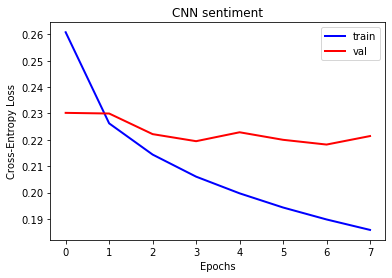

In [35]:
#generate plots
from google.colab import files
plt.figure()
plt.plot(hist.history['loss'], lw=2.0, color='b', label='train')
plt.plot(hist.history['val_loss'], lw=2.0, color='r', label='val')
plt.title('CNN sentiment')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend(loc='upper right')
plt.savefig('training & validation LossAmazonPolarityFT.pdf')
files.download('training & validation LossAmazonPolarityFT.pdf') 
plt.show()

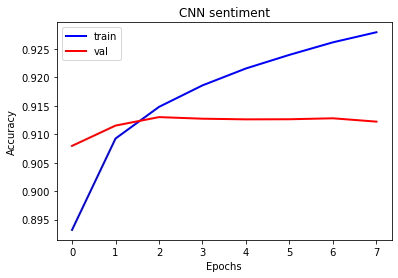

In [36]:
plt.figure()
plt.plot(hist.history['acc'], lw=2.0, color='b', label='train')
plt.plot(hist.history['val_acc'], lw=2.0, color='r', label='val')
plt.title('CNN sentiment')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.savefig('training & validation accuracyAmazonPolarityFT.pdf')
files.download('training & validation accuracyAmazonPolarityFT.pdf')
plt.show()